# Python simulation framework - Optimization demo


---


## <span style="color:red">Note: This tutorial uses the same simulation, parameter and dose tables as defined in the [Simulation Tutorial](psf_simulations.ipynb)</span>.


### Import packages


In [1]:
# Import the simulation framework
import abm

# Also import other packages
# Numpy
import numpy as np

# Pandas
import pandas as pd

# Plotnine (ggplot for Python)
import plotnine as p9

---

## Parameter optimization

The simulation framwework provides a table-based interface to the QSP Notebook's parameter optimization functionality. We will go through an example fitting to a synthetic RO dataset. Running a fit involves creating a **data table**, a **parameter table**, and a **dose table**.

### Data table

When fitting to a single set of experimental data, the required column names are:

- `'time'` for the timepoints (x-axis). These data can be in any standard time units ("fs", "ps", "ns", "us", "ms", "s", "min", "hr", "d", "w"). Individual entries can not be mixed units (ie, you can not input 1 d 3 hr - this must be converted to 27 hr or 1.125 d)
- `'time_unit'` for the units of the time value in the data table. These do not need to match the model file time units or be the same for all data points.
- `'measurement'` for the data to be fit (y-axis). For this example, these data are in nM.
- `'measurement_unit'` for the units of the measurement. The measurement units can be any combination of acceptable units listed in the preamble of the example model file.
- `'output'` for the model output or state variable that the data is fitted to.
- Either a `'constant_error'`, `'exponential_error'`, or `'proportional_error'` which defines the error for each data point. In this example, we use an exponential error of 0.1, or 10%. (See below for more information on error models.) Separate datapoints can use different error models for fitting by including the other error column and setting one of the values to 0. For example, if I wanted to fit row 0 in the above DataTable using the constant error model, the exponential_error element would be '0' and the constant_error element would be '10' or another value. The constant error model assumes that the units of error are the same as the units of the measurement at that time point.

Below we load the dataset. It is already in the appropriate format for using the Python simulation framework.


,burden,binding_strength,dose_mpk,time,time_unit,output,measurement,measurement_unit,constant_error,constant_error_unit
0,low,strong,0.000010,2,d,receptor_occupancy,4.876369,1,error,1
1,low,strong,0.000027,2,d,receptor_occupancy,0.000000,1,error,1
2,low,strong,0.000072,2,d,receptor_occupancy,2.620207,1,error,1
3,low,strong,0.000193,2,d,receptor_occupancy,5.298750,1,error,1
4,low,strong,0.000518,2,d,receptor_occupancy,1.129469,1,error,1


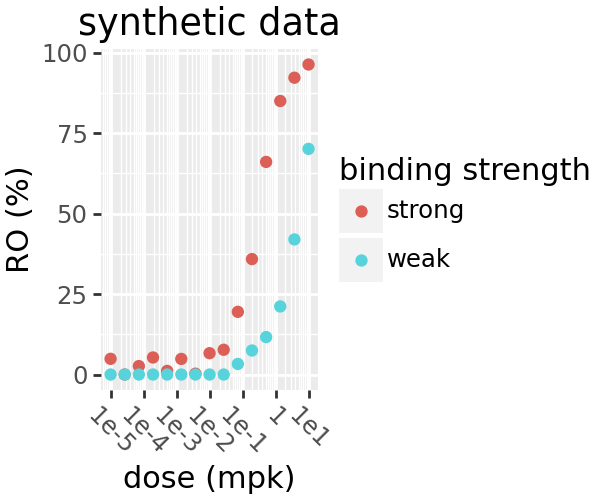

In [3]:
# Read synthetic data table
Tdat = pd.read_csv("./tables/data_table_psf.csv")
display(Tdat.head())
# Plot the data
(
    p9.ggplot(Tdat, p9.aes("dose_mpk", "measurement", color="binding_strength"))
    + p9.geom_point()
    + p9.scale_x_log10(breaks=10.0 ** np.arange(-5, 2))
    + p9.labs(
        x="dose (mpk)", y="RO (%)", color="binding strength", title="synthetic data"
    )
    + p9.theme(figure_size=(3, 2.5), axis_text_x=p9.element_text(rotation=-45))
)

Let's look at the format:


The table is essentially an augmented simulation table. Just like the simulation table, the data table contains descriptive columns `burden`, `binding_strength`, and `dose_mpk` that describe the simulation each data point belongs to. These work the same way as the label columns of the simulation table. These columns will be matched up with the like-named columns in the parameter and dose tables to determine which parameter values and doses should be used to simulate each data point.


The objective functions for the error models are:

- **Constant error**, which penalizes deviations proportionally to the _absolute_ difference between the model and data values. Constant error is in the same units as the model and data values.
- Objective function: `G = sum(log(s) + (model - data)^2 / s)`, where `s = error ^ 2`
- **Exponential error**, which penalizes deviations proportionally to the difference between the logs of the model and data values. Exponential error is in fractional units (i.e., a value of 0.2 corresponds to a 20% error in log space).
- Objective function: `G = sum(2 * log(s) + ((log(model) - log(data)) / s) ^ 2)`, where `v = error`
- **Proportional error**, which penalizes deviations based on the difference between the model and data values proportionally to the model values and error. Proportional error is in fractional units (i.e., a value of 0.2 corresponds to a 20% error).
- Objective function: `G = sum(log(s) + (model - data)^2 / s)`, where `s = (error * model) ^ 2`

**Should I use constant or exponential/proportional error?** Typically, constant error is more appropriate for outputs best visualized on a linear scale (such as receptor occupancy), while exponential and proportional error is more appropriate for outputs visualized on a log scale (such as PK). One reason to choose proportional error over exponential error is if you'd like to use a combined error model: constant + proportional error model is the only combination available currently.

**How do I choose an error value?** Roughly speaking, the value of the error sets a "typical" amount of deviation of the model from the data. More specifically, to calculate the penalty, the data points are assumed to be drawn from normal distributions centered at each model-predicted value, and the standard deviation of these normal distributions is set by the error. If there are replicate measurements available, one good choice for the error is the estimated standard error of the replicates ($s \over \sqrt{n}$, where $s$ is the sample standard deviation of the replicates and $n$ is the number of replicates). If you don't have estimates of the measurement error available, a good rule of thumb is to imagine how large the error bars should appear on a plot of the data and set the error value accordingly.

Additionally, you can fit an error value during optimization, as shown in the example below.

**How do I set the error?** To set the error, include at least one of the following columns in your data table:

- `'constant_error'` to define the constant error for each data point.
- `'exponential_error'` to define the exponential error for each data point.
- `'proportional_error'` to define the proportional error for each data point.

Every data point should have a nonzero value for only one of the two error columns, unless using the combined constant + proportional error models.


### Parameter table

Below we view the parameter table. It is already in the appropriate format for using the Python simulation framework.


In [5]:
pd.read_csv("./tables/par_table_optimization_psf.csv")

,binding_strength,burden,parameter,value,unit,is_fit,lower_bound,upper_bound,prior_distribution
0,*,*,volume_central,6.000000e+00,L,False,0.0,inf,loguniform
1,*,low,R1_per_cell,1.000000e+04,1,False,0.0,inf,loguniform
2,*,high,R1_per_cell,1.000000e+06,1,False,0.0,inf,loguniform
3,*,*,cell_per_mL,1.000000e+04,(1/mL),False,0.0,inf,loguniform
4,*,*,kon,1.000000e-03,(1/nM/s),False,0.0,inf,loguniform
5,strong,*,kd_mab,1.000000e-10,M,True,0.0,inf,loguniform
6,weak,*,kd_mab,2.000000e-09,M,True,0.0,inf,loguniform
7,*,*,el_half,2.800000e+01,d,False,0.0,inf,loguniform
8,*,*,abs_half,2.500000e+00,d,False,0.0,inf,loguniform
9,*,*,R1_half,6.000000e+01,min,False,0.0,inf,loguniform


The parameter table is similar to the parameter table used in simulations but has a few additional columns. The columns are

1. a `parameter` column with the names of parameters
2. a `value` column with the parameter values
3. a `unit` column with the unit for each parameter. This unit value can be any combination of acceptable units defined in the model example file. The units of the parameters within the parameter table do not need to exactly match the units of the model file - but must be compatible.
4. an `is_fit` column, a boolean to choose which parameters to fit
5. a `lower_bound` column with the lower bounds of the parameter values. Empty strings ('') and NaNs in this column are internally converted to zero.
6. an `upper_bound` column with the upper bounds of the parameter values. Empty strings ('') and NaNs in this column are internally converted to infinity.
7. an _optional_ `prior_distribution` column to define the prior for each parameter. The options are `'loguniform'` and `'uniform'`. If this column is ommitted, the default value for the prior distribution is `'loguniform'`. The choice of prior distribution should be made based on the search range of the parameter. If a parameter value should be scanned and optimized over log space to distinguish between values over a range of multiple orders of magnitude, then the `'loguniform'` option should be used. Otherwise the `'uniform'` option should be used.

The table may also have label columns to indicate which parameters should be used for which data points.

Note that not setting lower or upper bounds can cause the optimizer to fail; it's encouraged to provide these values, even if they are orders of magnitude apart.


### Dose table


The dose table works the same way for optimization as for simulation. The below code generates the dose table from the data table.


In [6]:
Tdos_fit = Tdat[["dose_mpk"]].copy().drop_duplicates(ignore_index=True)
Tdos_fit["amounts"] = Tdos_fit.dose_mpk
Tdos_fit["amount_unit"] = "(mg/kg)"
Tdos_fit["times"] = 0.0
Tdos_fit["time_unit"] = "s"
Tdos_fit["route"] = "IV_mpk"

Tdos_fit

,dose_mpk,amounts,amount_unit,times,time_unit,route
0,0.000010,0.000010,(mg/kg),0.0,s,IV_mpk
1,0.000027,0.000027,(mg/kg),0.0,s,IV_mpk
2,0.000072,0.000072,(mg/kg),0.0,s,IV_mpk
3,0.000193,0.000193,(mg/kg),0.0,s,IV_mpk
4,0.000518,0.000518,(mg/kg),0.0,s,IV_mpk
5,0.001389,0.001389,(mg/kg),0.0,s,IV_mpk
6,0.003728,0.003728,(mg/kg),0.0,s,IV_mpk
7,0.010000,0.010000,(mg/kg),0.0,s,IV_mpk
8,0.026827,0.026827,(mg/kg),0.0,s,IV_mpk
9,0.071969,0.071969,(mg/kg),0.0,s,IV_mpk


### Running the fit

We use `abm.optimize` to run our simulations.


In [7]:
optimization = abm.optimize(
    measurements="./tables/data_table_psf.csv",
    models="model_files/antireceptor_model_1compartment-1.txt",
    parameters="./tables/par_table_optimization_psf.csv",
    doses=Tdos_fit,
    method="fides-BFGS",
    max_iterations=1000,
    min_objective=-np.inf,
    opttol=1e-8,
    gradient_method="adjoint",
    linear_solver="KLU",
    reltol=1e-6,
    abstol=1e-9,
    maxord=5,
    nonnegative=False,
)

Total: 0, Running: 0, Succeeded: 0, Failed: 0

iteration,objective,kd_mab_fit_5,error_fit_18,kd_mab_fit_6
0,689.568406,1.000000e-10,10.000000,2.000000e-09
1,321.355320,1.038391e-10,19.424941,2.227291e-09
2,292.706355,1.460528e-10,19.884970,5.693958e-09
3,242.104802,4.444334e-10,21.321151,2.976844e-08
4,187.406913,1.066810e-08,21.965240,3.373566e-07
5,185.049795,4.149730e-08,20.478463,7.432899e-07
6,181.208161,1.641080e-08,18.578665,1.165713e-06
7,174.536435,1.148389e-08,17.429095,2.687441e-07
8,157.554842,1.471007e-08,13.218740,2.846756e-07
9,130.803546,1.861534e-08,8.465746,3.342648e-07


The result of the fit is an `OptimizationResult` object containing the fitted parameters and the tables used to configure the fit.


### Getting the fit parameter table


The fitted parameter values can be found in the `fit_parameter_table` attribute, as shown below. The parameter table has the same form as the input parameter table, and the fit parameters have their values replaced with the optimized values.

Like the results of a simulation, the parameter table can be returned in different formats using several different methods. Listed below:

- `to_data_pipe() -> RemoteAnalysis`
- `to_data_frame() -> RemoteDataTable`
- `to_tabeline() -> tl.DataFrame`
- `to_pandas() -> pd.DataFrame`


In [8]:
optimization.fit_parameter_table.to_pandas()

,binding_strength,burden,parameter,value,unit,is_fit,lower_bound,upper_bound,prior_distribution,global_parameter_name
0,*,*,volume_central,6.000000e+00,L,False,0.0,inf,loguniform,volume_central_fit_0
1,*,low,R1_per_cell,1.000000e+04,1,False,0.0,inf,loguniform,R1_per_cell_fit_1
2,*,high,R1_per_cell,1.000000e+06,1,False,0.0,inf,loguniform,R1_per_cell_fit_2
3,*,*,cell_per_mL,1.000000e+04,(1/mL),False,0.0,inf,loguniform,cell_per_mL_fit_3
4,*,*,kon,1.000000e-03,(1/nM/s),False,0.0,inf,loguniform,kon_fit_4
5,strong,*,kd_mab,2.164342e-08,M,True,0.0,inf,loguniform,kd_mab_fit_5
6,weak,*,kd_mab,3.500324e-07,M,True,0.0,inf,loguniform,kd_mab_fit_6
7,*,*,el_half,2.800000e+01,d,False,0.0,inf,loguniform,el_half_fit_7
8,*,*,abs_half,2.500000e+00,d,False,0.0,inf,loguniform,abs_half_fit_8
9,*,*,R1_half,6.000000e+01,min,False,0.0,inf,loguniform,R1_half_fit_9


### Simulating the fit parameters

The optimized parameters may be used to simulate the data set using the `simulate` method of the `OptimizationResult`. This returns a `SimulationResult` object containing the fitted outputs for simulations of the data sets.

For this example the `.to_pandas(tall_outputs = True)` method was used to save the results of the simulation using fitted parameters as a pandas table.


In [9]:
# Get a SimulationResult containing the simulations of the data set and convert to pandas DataFrame
Tfit = optimization.simulate().to_pandas(tall_outputs=True)

/opt/pixi/cache/envs/abm-platform-training-11393412784987863449/envs/default/lib/python3.12/site-packages/abm/_simulate.py:355: UserWarning: Parameters not present in the model will be ignored: error 


Total: 0, Running: 0, Succeeded: 0, Failed: 0

Don't worry about the warning in this case. The framework is warning us that there's a parameter in the parameter table that isn't in the model and therefore does nothing. The `error` parameter only appears in the `constant_error` column and not in the model, so it only impacts the fit and not the simulation.


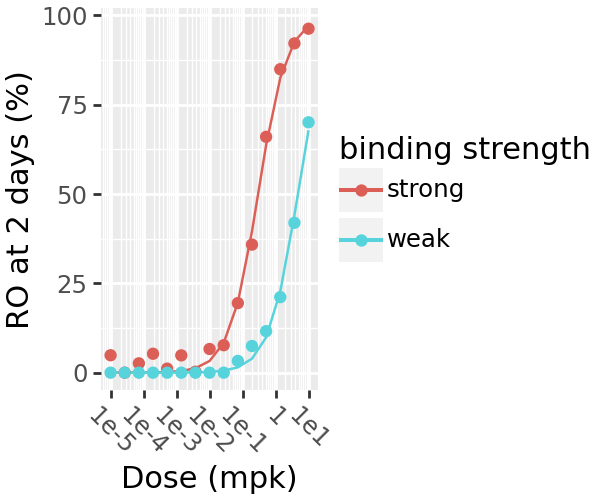

In [10]:
(
    p9.ggplot(mapping=p9.aes(x="dose_mpk", color="binding_strength"))
    + p9.geom_line(data=Tfit, mapping=p9.aes(y="value", color="binding_strength"))
    + p9.geom_point(data=Tdat, mapping=p9.aes(y="measurement"))
    + p9.scale_x_log10(breaks=10.0 ** np.arange(-5, 2))
    + p9.labs(x="Dose (mpk)", y="RO at 2 days (%)", color="binding strength")
    + p9.theme(figure_size=(3, 2.5), axis_text_x=p9.element_text(rotation=-45))
)

When applied to a OptimizationResult, `simulate` by default only returns the times and the outputs found in the data table. If you would like to return additional time points or outputs, you can utilize the `outputs` and `times` input arguments. Any outputs or times specified will be returned in addition to those found in the data table. This is useful for debugging fits by plotting other model outputs or for simulating a finer grid of time points to make the plotted curves smoother.

In the below example, we simulate out to day 4 instead of day 2 to see if the results change significantly.


In [11]:
Tfit_day4 = optimization.simulate(times=["4.0:d"]).to_pandas(tall_outputs=True)

/opt/pixi/cache/envs/abm-platform-training-11393412784987863449/envs/default/lib/python3.12/site-packages/abm/_simulate.py:355: UserWarning: Parameters not present in the model will be ignored: error 


Total: 0, Running: 0, Succeeded: 0, Failed: 0

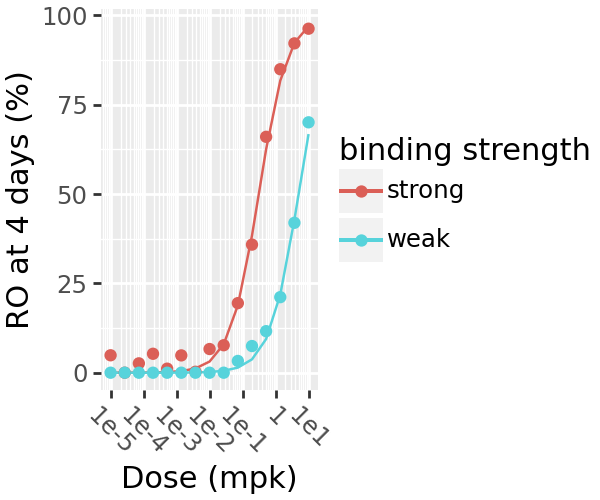

In [12]:
(
    p9.ggplot(
        data=Tfit_day4,
        mapping=p9.aes(x="dose_mpk", y="value", color="binding_strength"),
    )
    + p9.geom_line()
    + p9.geom_point(data=Tdat, mapping=p9.aes(y="measurement"))
    + p9.scale_x_log10(breaks=10.0 ** np.arange(-5, 2))
    + p9.labs(x="Dose (mpk)", y="RO at 4 days (%)", color="binding strength")
    + p9.theme(figure_size=(3, 2.5), axis_text_x=p9.element_text(rotation=-45))
)

## Obtaining confidence intervals on the fitted parameters

To obtain the confidence intervals we use the Fisher Information Matrix that can be obtained in the platform. Then we call confidence_intervals methods with the fraction of the distribution to contain within the confidence interval (0.95 to obtain 95% confidence intervals). Additional resources (explainations and plotting utilities) on CI calculations will be available soon.

The default assumes a lognormal distribution on the parameters. Changes to this assumption to a normal distribution must be made during in the parameter table prior to optimization, but refer to the warning in the documentation about changing this assumption.


In [13]:
ci = optimization.confidence_intervals(0.95)
ci

,parameter,value,unit,scale,lower,upper
0,kd_mab_fit_5,2.164342e-08,M,log,1.945158e-08,2.408224e-08
1,error_fit_18,2.217964e+00,1,linear,1.656752e+00,2.779177e+00
2,kd_mab_fit_6,3.500324e-07,M,log,3.126911e-07,3.918330e-07


## Obtaining the residuals from the optimization

We can also obtain the residuals (the difference between the simulation values and experimental data) through the platform. We only have to use the `Residual` object and pass the optimization obtained previously.

Note that the `objective` column is calculated with our own internal objective functions (see above).


In [14]:
residuals_df = optimization.residuals().to_pandas()
residuals_df

,burden,binding_strength,dose_mpk,id,time,time_unit,target,measurement,unit,prediction,residual,normalized_residual,log_likelihood
0,low,strong,0.000010,0,172800.0,s,receptor_occupancy,4.876369,1,0.003389,4.872980,2.197051,-4.129044
1,low,strong,0.000027,1,172800.0,s,receptor_occupancy,0.000000,1,0.009091,-0.009091,-0.004099,-1.715537
2,low,strong,0.000072,2,172800.0,s,receptor_occupancy,2.620207,1,0.024384,2.595823,1.170363,-2.400403
3,low,strong,0.000193,3,172800.0,s,receptor_occupancy,5.298750,1,0.065389,5.233362,2.359534,-4.499228
4,low,strong,0.000518,4,172800.0,s,receptor_occupancy,1.129469,1,0.175226,0.954243,0.430234,-1.808079
5,low,strong,0.001389,5,172800.0,s,receptor_occupancy,4.847354,1,0.468696,4.378658,1.974179,-3.664219
6,low,strong,0.003728,6,172800.0,s,receptor_occupancy,0.260030,1,1.247532,-0.987502,-0.445229,-1.814643
7,low,strong,0.010000,7,172800.0,s,receptor_occupancy,6.627115,1,3.277954,3.349160,1.510015,-2.855602
8,low,strong,0.026827,8,172800.0,s,receptor_occupancy,7.691022,1,8.334162,-0.643140,-0.289968,-1.757569
9,low,strong,0.071969,9,172800.0,s,receptor_occupancy,19.474665,1,19.608642,-0.133976,-0.060405,-1.717353
